In [1]:
!pip install catboost category_encoders optuna lime

In [2]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import networkx as nx
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import f1_score, classification_report
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
import category_encoders as ce
import lime.lime_tabular

warnings.filterwarnings('ignore')

In [3]:
catboost_params =  {'iterations': 343, 'depth': 5, 'learning_rate': 0.22515528051401798, 'l2_leaf_reg': 6.781548809725471,
    "eval_metric": "F1",
    "random_state": 42,
    "verbose":False
}

In [4]:
data = pd.read_csv("data.csv")
data

CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
0             619    France       0   42       2       0.00              1   
1             608     Spain       0   41       1   83807.86              1   
2             502    France       0   42       8  159660.80              3   
3             699    France       0   39       1       0.00              2   
4             850     Spain       0   43       2  125510.82              1   
...           ...       ...     ...  ...     ...        ...            ...   
9995          771    France       1   39       5       0.00              2   
9996          516    France       1   35      10   57369.61              1   
9997          709    France       0   36       7       0.00              1   
9998          772   Germany       1   42       3   75075.31              2   
9999          792    France       0   28       4  130142.79              1   

      HasCrCard  IsActiveMember  EstimatedSalary  Exited  \
0             1               1        101348.88       1   
1             0               1        112542.58       0   
2             1               0        113931.57       1   
3             0               0         93826.63       0   
4             1               1         79084.10       0   
...         ...             ...              ...     ...   
9995          1               0         96270.64       0   
9996          1               1        101699.77       0   
9997          0               1         42085.58       1   
9998          1               0         92888.52       1   
9999          1               0         38190.78       0   

      MeanBalance_Neighbors  Balance_to_Salary  IsHighCreditScore  
0                 3699.0225           0.000000                  0  
1               104578.2472           0.744670                  0  
2               127615.3905           1.401362                  0  
3                    0.0000           0.000000                  0  
4               117565.9444           1.587035                  1  
...                     ...                ...                ...  
9995                 0.0000           0.000000                  1  
9996             70010.5443           0.564102                  0  
9997              4848.7801           0.000000                  1  
9998             99965.5186           0.808222                  1  
9999            126331.1484           3.407613                  1  

[10000 rows x 14 columns]

In [5]:
def work_with_features(X):
    X = X.copy()

    return X


In [6]:
X = data.drop(columns='Exited')
y = data['Exited']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

encoder = ce.TargetEncoder(cols="Geography", smoothing=5)
encoder.fit(X_train["Geography"], y_train)

TargetEncoder(cols=['Geography'], smoothing=5)

In [7]:
X_train_encoded = encoder.transform(X_train["Geography"])
X_test_encoded = encoder.transform(X_test["Geography"])

X_train_final = pd.concat([X_train.drop("Geography", axis=1), X_train_encoded], axis=1)
X_test_final = pd.concat([X_test.drop("Geography", axis=1),  X_test_encoded], axis=1)

X_train_final = work_with_features(X_train_final)
X_test_final = work_with_features(X_test_final)

In [8]:
cb = CatBoostClassifier(**catboost_params)
cb.fit(X_train_final, y_train)
y_proba = cb.predict_proba(X_test_final)[:, 1]

In [9]:
thresholds = np.arange(0.1, 0.9, 0.01)
scores = []

for t in thresholds:
    y_pred_temp = (y_proba > t).astype(int)
    f1 = f1_score(y_test, y_pred_temp)
    scores.append(f1)

best_threshold = thresholds[np.argmax(scores)]
best_f1 = max(scores)

In [10]:
def biniraize_proba(y_proba):
    return (y_proba[:, 1] > 0.38).astype(int)

In [11]:
print(f"Лучший Threshold: {best_threshold:.2f}")
print(f"Максимальный F1-score: {best_f1:.4f}")

y_pred_default = (y_proba > 0.5).astype(int)
y_pred_optimal = (y_proba > best_threshold).astype(int)

print(classification_report(y_test, y_pred_optimal))

plt.figure(figsize=(10, 6))
plt.plot(thresholds, scores, label='F1 Score')
plt.axvline(best_threshold, color='r', linestyle='--', label=f'Best Threshold {best_threshold:.2f}')
plt.title('Зависимость F1-score от порога (Threshold)')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()

Лучший Threshold: 0.38
Максимальный F1-score: 0.6227
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      1607
           1       0.65      0.60      0.62       393

    accuracy                           0.86      2000
   macro avg       0.78      0.76      0.77      2000
weighted avg       0.85      0.86      0.85      2000



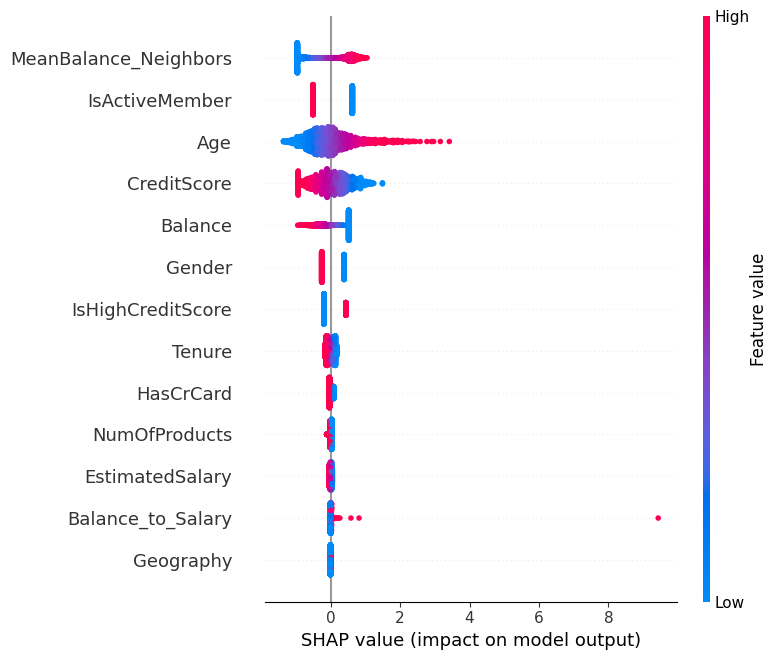

In [12]:

model_lr = LogisticRegression(max_iter=1000, random_state=42).fit(X_train_final, y_train)
model_cb = CatBoostClassifier(**catboost_params).fit(
    X_train_final, y_train, eval_set=(X_test_final, y_test)
)

# shap ----------------------------------------------


explainer_cb = shap.TreeExplainer(model_cb)
shap_values_cb = explainer_cb.shap_values(X_test_final)
shap.summary_plot(shap_values_cb, X_test_final, title="SHAP CatBoost")

explainer_lr = shap.LinearExplainer(model_lr, X_train_final)
shap_values_lr = explainer_lr.shap_values(X_test_final)
shap.summary_plot(shap_values_lr, X_test_final, title="SHAP Logit")

# lime ----------------------------------------------

idx = 0
feature_short_names_alt = {
    'CreditScore': 'CrScore',
    'Geography': 'Geo',
    'Gender': 'Sex',
    'Age': 'Age',
    'Tenure': 'Tenure',
    'Balance': 'Bal',
    'NumOfProducts': 'Products',
    'HasCrCard': 'Card',
    'IsActiveMember': 'Active',
    'EstimatedSalary': 'Salary',
    'MeanBalance_Neighbors': 'NbrAvgBal',
    'Balance_to_Salary': 'Bal/Sal',
    'IsHighCreditScore': 'HiCredit'
}


short_feature_names = [feature_short_names_alt.get(col, col)
                       for col in X_train_final.columns.tolist()]

explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_final.values,
    feature_names=short_feature_names,
    class_names=['Stay', 'Exit'],
    mode='classification'
)

exp_cb = explainer_lime.explain_instance(X_test_final.iloc[idx].values, model_cb.predict_proba)
exp_cb.show_in_notebook()
# fig = exp_cb.as_pyplot_figure()
# fig.set_size_inches(6, 6)
# plt.tight_layout()
# plt.show()


exp_lr = explainer_lime.explain_instance(X_test_final.iloc[idx].values, model_lr.predict_proba)
exp_lr.show_in_notebook()
# fig = exp_lr.as_pyplot_figure()
# fig.set_size_inches(6, 6)
# plt.tight_layout()
# plt.show()

shap.initjs()
shap.force_plot(explainer_cb.expected_value, shap_values_cb[idx], X_test_final.iloc[idx])

SHAP
1) catboost и логит показали схожие результаты, но как мы можем заметить, линейная модель выражалась более категорично
2) главные признаки схожи, но их порядок немоного различается

LIME
1) реузльтаты разные

In [13]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

In [14]:
def get_shap_embeddings(model, X):
    explainer = shap.TreeExplainer(model)
    return explainer.shap_values(X)

In [15]:
model_base = CatBoostClassifier(**catboost_params)
model_base.fit(X_train_final, y_train)
shap_embs = get_shap_embeddings(model_base, X_train_final)

scaler = StandardScaler()
shap_embs = scaler.fit_transform(shap_embs)

shap_sum = np.abs(shap_embs).sum(axis=1)
threshold = np.percentile(shap_sum, 95)
clean_mask = shap_sum < threshold

In [16]:
X_train_clean = X_train_final[clean_mask]
y_train_clean = y_train[clean_mask]

model_clean = CatBoostClassifier(**catboost_params)
model_clean.fit(X_train_clean, y_train_clean)

In [17]:
dbsq = KMeans(n_clusters=3, random_state=42)
clusters = dbsq.fit_predict(shap_embs)

tsne = TSNE(n_components=2, random_state=42)
shap_2d = tsne.fit_transform(shap_embs)

plt.figure(figsize=(6, 6))
plt.scatter(shap_2d[:, 0], shap_2d[:, 1], c=clusters, cmap='viridis')
plt.title("SHAP Clusters")
plt.show()

In [18]:
X_train_with_cl = X_train_final.copy()
X_train_with_cl['cluster'] = clusters

test_shap_embs = get_shap_embeddings(model_base, X_test_final)
X_test_with_cl = X_test_final.copy()
X_test_with_cl['cluster'] = dbsq.predict(test_shap_embs)

model_cluster = CatBoostClassifier(**catboost_params)
model_cluster.fit(X_train_with_cl, y_train)

In [19]:
print(f"Base F1: {f1_score(y_test, biniraize_proba(model_base.predict_proba(X_test_final))):.3f}")
print(f"Clean F1: {f1_score(y_test, biniraize_proba(model_clean.predict_proba(X_test_final))):.3f}")
print(f"Cluster F1: {f1_score(y_test, model_cluster.predict(X_test_with_cl)):.3f}")

Base F1: 0.623
Clean F1: 0.591
Cluster F1: 0.583


In [20]:
df_analysis = X_train_final.copy()

df_analysis['cluster'] = clusters

df_analysis['Exited'] = y_train.values

cluster_stats = df_analysis.groupby('cluster').mean()
print(cluster_stats)

print("Доля оттока (Exited) по кластерам:")
print(df_analysis.groupby('cluster')['Exited'].mean().sort_values(ascending=False))

         CreditScore    Gender        Age    Tenure        Balance  \
cluster                                                              
0         651.156250  0.414062  43.855469  5.132812   80549.100273   
1         652.048669  0.568174  37.561065  5.061794   62880.847222   
2         650.728964  0.504429  41.583260  4.848539  107720.203556   

         NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  \
cluster                                                              
0             3.175781   0.691406        0.437500    105714.760117   
1             1.530259   0.704703        0.555049     98850.424275   
2             1.347653   0.701949        0.418512    103673.123096   

         MeanBalance_Neighbors  Balance_to_Salary  IsHighCreditScore  \
cluster                                                                
0                 77865.660788           1.798900           0.300781   
1                 63493.782665           2.307976           0.310791   
2         

In [21]:
import shap
import matplotlib.pyplot as plt
import numpy as np


def plot_shapley_flow_per_cluster(explainer, shap_values, X, clusters, cluster_labels=None):
    expected_value = explainer.expected_value

    if isinstance(expected_value, list) or isinstance(expected_value, np.ndarray):
        expected_value = expected_value[1] if len(expected_value) > 1 else expected_value[0]

    unique_clusters = np.unique(clusters)

    for cl in unique_clusters:
        indices = np.where(clusters == cl)[0]

        if len(indices) == 0: continue

        cluster_shap = shap_values[indices]
        cluster_X = X.iloc[indices]
        mean_shap = np.mean(cluster_shap, axis=0)
        mean_features = cluster_X.mean(axis=0)

        plt.figure(figsize=(10, 6))
        plt.title(f"SF ДЛЯ КЛАСТЕРА:  {cl}")

        shap.decision_plot(
            expected_value,
            mean_shap,
            features=mean_features,
            feature_names=X.columns.tolist(),
            show=False,
            link='logit'
        )
        plt.show()

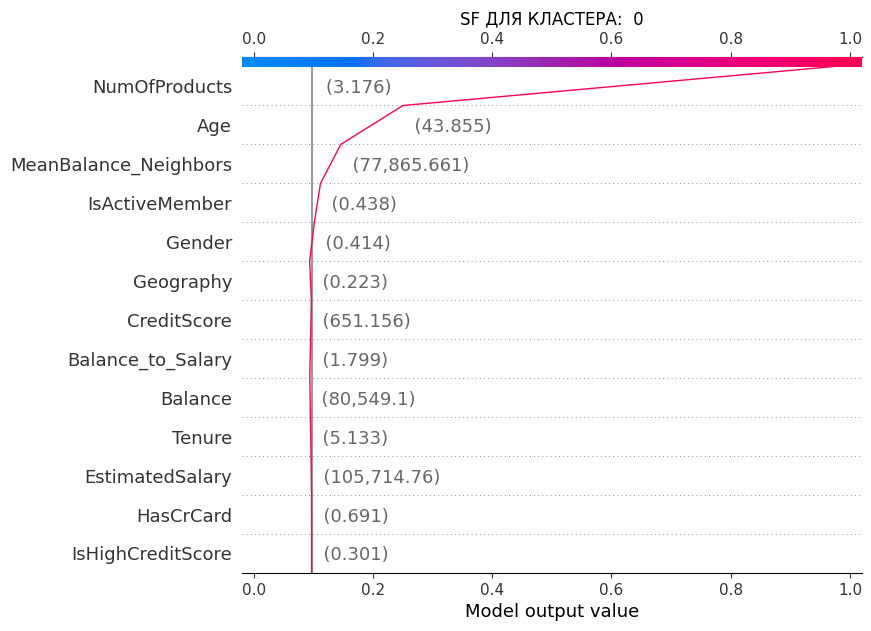

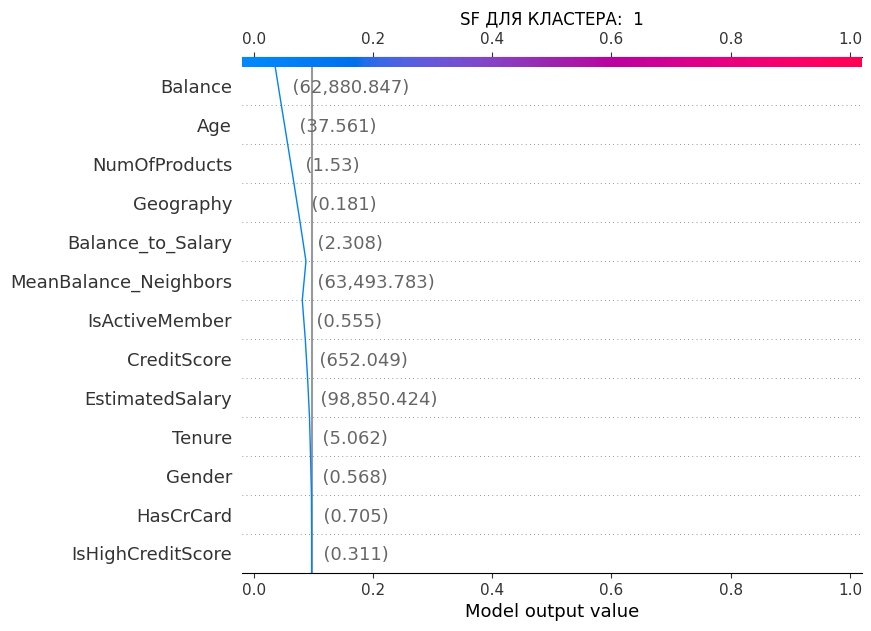

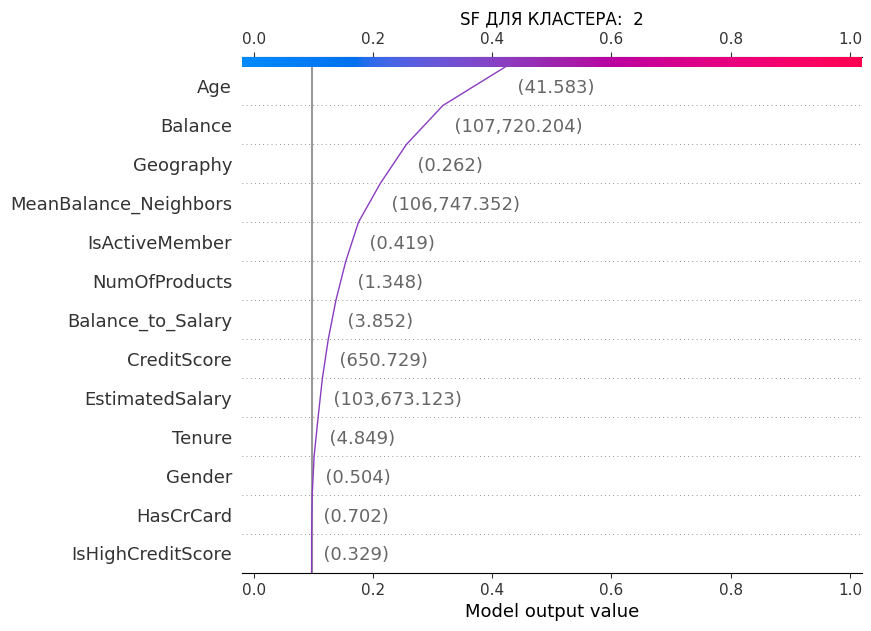

In [22]:
explainer = shap.TreeExplainer(model_base)
shap_values = explainer.shap_values(X_train_final)
plot_shapley_flow_per_cluster(explainer, shap_values, X_train_final, clusters)